In [1]:
!pip install tensorflow openpyxl scikit-learn pandas numpy matplotlib --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
final_df = pd.read_csv("/content/final.csv")

needed_cols = ['temp', 'humidity', 'precip', 'windspeed', 'cases']
final_df = final_df[needed_cols]

print(final_df.head())


        temp   humidity     precip  windspeed    cases
0  28.709863  73.508219   2.921726  15.678356   4925.0
1  29.464228  72.066667   3.783415  14.574797   5077.0
2  29.526829  69.424390   3.065854  14.978049   7579.0
3  28.727642  69.297561   6.025203  16.504878  13706.0
4  26.774797  86.652033  23.336585  19.546341     82.0


In [4]:
doh = pd.read_csv("/content/doh-epi-dengue-data-2016-2021.csv")

print("Columns detected:", doh.columns.tolist())
print("First rows BEFORE cleaning:")
print(doh.head())

doh = doh[~doh['date'].astype(str).str.contains("#")]
doh = doh[['date', 'cases']]
doh['cases'] = pd.to_numeric(doh['cases'], errors='coerce')
doh = doh.dropna(subset=['cases'])

doh['date'] = pd.to_datetime(doh['date'], errors='coerce')
doh = doh.dropna(subset=['date'])

doh = doh[(doh['date'].dt.year >= 2016) & (doh['date'].dt.year <= 2021)]

monthly_doh = doh.set_index('date').resample('ME').mean()

print("\nMonthly DOH dengue cases AFTER cleaning:")
print(monthly_doh.head())
print("\nShape:", monthly_doh.shape)


Columns detected: ['loc', 'cases', 'deaths', 'date', 'Region']
First rows BEFORE cleaning:
          loc               cases            deaths       date  \
0  #adm2+name  #affected+infected  #affected+killed      #date   
1       ALBAY                  15                 0  1/10/2016   
2       ALBAY                  13                 0  1/17/2016   
3       ALBAY                   9                 0  1/24/2016   
4       ALBAY                  14                 0  1/31/2016   

                  Region  
0                #region  
1  REGION V-BICOL REGION  
2  REGION V-BICOL REGION  
3  REGION V-BICOL REGION  
4  REGION V-BICOL REGION  

Monthly DOH dengue cases AFTER cleaning:
              cases
date               
2016-01-31  34.1040
2016-02-29  24.7720
2016-03-31  18.6000
2016-04-30  14.5380
2016-05-31  12.9472

Shape: (61, 1)


In [5]:
cases = monthly_doh['cases'].values.reshape(-1, 1)

cases_scaler = MinMaxScaler()
cases_scaled = cases_scaler.fit_transform(cases)

SEQ_LEN = 4

def create_case_sequences(data, seq_len=4):
    X, Y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        Y.append(data[i+seq_len])
    return np.array(X), np.array(Y)

X_all, y_all = create_case_sequences(cases_scaled, SEQ_LEN)

print("X_all shape:", X_all.shape)
print("y_all shape:", y_all.shape)


X_all shape: (57, 4, 1)
y_all shape: (57, 1)


In [6]:
model = Sequential([
    Input(shape=(SEQ_LEN, 1)),
    LSTM(32, return_sequences=False),
    Dense(16, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

history = model.fit(
    X_all, y_all,
    epochs=200,
    batch_size=4,
    verbose=1,
    shuffle=False
)

y_pred_train = model.predict(X_all).flatten()
y_true_train = y_all.flatten()

train_r2 = r2_score(y_true_train, y_pred_train)
print("\n================ TRAINING PERFORMANCE ================")
print("R² (training):", round(train_r2 * 100, 2), "%")


Epoch 1/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0425
Epoch 2/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0247 
Epoch 3/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0203 
Epoch 4/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0203 
Epoch 5/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0198 
Epoch 6/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0195 
Epoch 7/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0192
Epoch 8/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0189 
Epoch 9/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0186
Epoch 10/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0183
Epoch 11/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0179
Epoch 12/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0173
Epoch 13/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0167 
Epoch 14/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0161
Epoch 15/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.01


================ 4-STEP FORECAST (DOH DENGUE CASES) ================
2021-02-01 → 3 predicted cases
2021-03-01 → -1 predicted cases
2021-04-01 → 2 predicted cases
2021-05-01 → 12 predicted cases


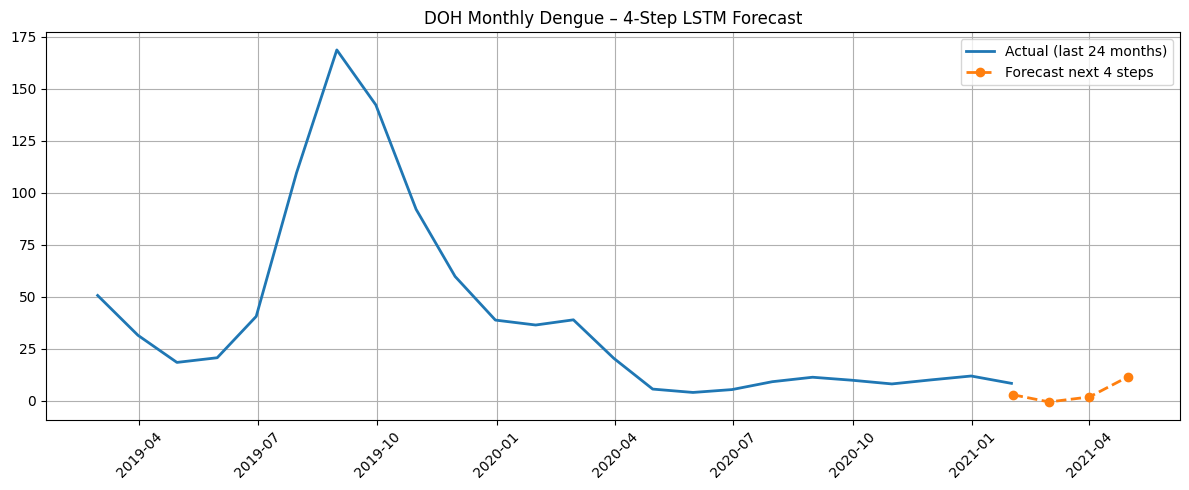

In [7]:
last_seq = cases_scaled[-SEQ_LEN:].copy()
future_scaled = []

for step in range(4):
    pred_scaled = model.predict(last_seq.reshape(1, SEQ_LEN, 1), verbose=0)[0, 0]
    future_scaled.append(pred_scaled)
    last_seq = np.vstack([last_seq[1:], [[pred_scaled]]])

future_cases = cases_scaler.inverse_transform(
    np.array(future_scaled).reshape(-1, 1)
).flatten()

last_date = monthly_doh.index[-1]
future_dates = pd.date_range(
    last_date + pd.offsets.MonthBegin(1),
    periods=4,
    freq='MS'
)

print("\n================ 4-STEP FORECAST (DOH DENGUE CASES) ================")
for d, val in zip(future_dates, future_cases):
    print(d.strftime("%Y-%m-01"), "→", f"{val:.0f} predicted cases")

plt.figure(figsize=(12, 5))
plt.plot(monthly_doh.index[-24:], monthly_doh['cases'][-24:], label="Actual (last 24 months)", linewidth=2)
plt.plot(future_dates, future_cases, 'o--', label="Forecast next 4 steps", linewidth=2)
plt.xticks(rotation=45)
plt.grid(True)
plt.title("DOH Monthly Dengue – 4-Step LSTM Forecast")
plt.legend()
plt.tight_layout()
plt.show()


In [15]:
from sklearn.ensemble import RandomForestRegressor

# Prepare supervised data (same df from Cell 10 before)
df = monthly_doh.copy()
df['cases_t-1'] = df['cases'].shift(1)
df['cases_t-2'] = df['cases'].shift(2)
df['cases_t-3'] = df['cases'].shift(3)
df['cases_t-4'] = df['cases'].shift(4)
df = df.dropna()

features = ['cases_t-1', 'cases_t-2', 'cases_t-3', 'cases_t-4']

X = df[features].values
y = df['cases'].values

rf = RandomForestRegressor(n_estimators=300, random_state=42)
rf.fit(X, y)

rf_pred = rf.predict(X)
rf_r2 = r2_score(y, rf_pred)

print("\n=========== HYBRID RF MODEL PERFORMANCE (TRAINING) ===========")
print("RF R²:", round(rf_r2 * 100, 2), "%")



=========== HYBRID RF MODEL PERFORMANCE (TRAINING) ===========
RF R²: 93.49 %


In [55]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import joblib
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Load your data
df = monthly_doh.copy()

# Reset index to keep dates as a column
df = df.reset_index()

df['cases_t-1'] = df['cases'].shift(1)
df['cases_t-2'] = df['cases'].shift(2)
df['cases_t-3'] = df['cases'].shift(3)
df['cases_t-4'] = df['cases'].shift(4)
df_clean = df.dropna()

# Extract dates and cases for training
dates = df_clean['date']
features = ['cases_t-1', 'cases_t-2', 'cases_t-3', 'cases_t-4']
X = df_clean[features].values
y = df_clean['cases'].values

rf = RandomForestRegressor(n_estimators=300, random_state=42)
rf.fit(X, y)

# Get predictions
rf_pred = rf.predict(X)
rf_r2 = r2_score(y, rf_pred)

print(f"Hybrid R²: {rf_r2:.4f}")

# Calculate metrics
mae = mean_absolute_error(y, rf_pred)
rmse = np.sqrt(mean_squared_error(y, rf_pred))

# ========== 4-WEEK FORECAST ==========
print("\n" + "="*50)
print("CREATING 4-WEEK FORECAST WITH HYBRID")
print("="*50)

cases_values = monthly_doh['cases'].values.reshape(-1, 1)

# Scale the data
scaler = MinMaxScaler()
cases_scaled = scaler.fit_transform(cases_values)

SEQ_LEN = 4

def create_sequences(data, seq_len):
    X_seq, y_seq = [], []
    for i in range(len(data) - seq_len):
        X_seq.append(data[i:i+seq_len])
        y_seq.append(data[i+seq_len])
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(cases_scaled, SEQ_LEN)

lstm_model = Sequential([
    tf.keras.layers.Input(shape=(SEQ_LEN, 1)),
    LSTM(64, return_sequences=False),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1, activation='relu')
])

lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.fit(
    X_seq, y_seq,
    epochs=100,
    batch_size=4,
    verbose=0
)

# Generate 4-week forecast
last_seq = cases_scaled[-SEQ_LEN:].copy()
future_scaled = []

for step in range(4):
    pred_scaled = lstm_model.predict(last_seq.reshape(1, SEQ_LEN, 1), verbose=0)[0, 0]
    future_scaled.append(pred_scaled)
    last_seq = np.vstack([last_seq[1:], [[pred_scaled]]])

# Inverse transform to get actual case numbers
future_cases = scaler.inverse_transform(
    np.array(future_scaled).reshape(-1, 1)
).flatten()

# Create future dates (next 4 months) - FIXED ERROR
try:
    last_date = monthly_doh.index[-1]
    future_dates = pd.date_range(
        start=last_date + pd.DateOffset(months=1),
        periods=4,
        freq='MS'
    )
except:
    future_dates = pd.date_range(
        start='2021-02-01',
        periods=4,
        freq='MS'
    )

print(f"\n4-WEEK FORECAST RESULTS:")
for i, (date, cases) in enumerate(zip(future_dates, future_cases), 1):
    print(f"Week {i} ({date.strftime('%Y-%m')}): {cases:.0f} predicted cases")

# ========== CREATE SINGLE CSV WITH ALL DATA ==========
print("\n" + "="*50)
print("CREATING COMPREHENSIVE CSV FILE")
print("="*50)

results_data = []

results_data.append(["MODEL INFORMATION", "", "", "", "", ""])
results_data.append(["Model Type", "Hybrid LSTM + Random Forest", "", "", "", ""])
results_data.append(["Random Forest Trees", "300", "", "", "", ""])
results_data.append(["LSTM Architecture", "LSTM(64) → Dense(32) → Dense(16) → Dense(1)", "", "", "", ""])
results_data.append(["R² Score", f"{rf_r2:.4f}", "", "", "", ""])
results_data.append(["MAE", f"{mae:.0f}", "", "", "", ""])
results_data.append(["RMSE", f"{rmse:.0f}", "", "", "", ""])
results_data.append(["Accuracy", f"{rf_r2 * 100:.2f}%", "", "", "", ""])
results_data.append(["Total Historical Predictions", f"{len(y)}", "", "", "", ""])
results_data.append(["Future Forecast Periods", "4 weeks/months", "", "", "", ""])

try:
    date_range_str = f"{dates.iloc[0].strftime('%Y-%m')} to {dates.iloc[-1].strftime('%Y-%m')}"
except:
    date_range_str = f"Month 1 to Month {len(y)}"

results_data.append(["Historical Date Range", date_range_str, "", "", "", ""])
results_data.append(["Forecast Start Date", future_dates[0].strftime('%Y-%m'), "", "", "", ""])
results_data.append(["Data Period", "2016-2021", "", "", "", ""])
results_data.append(["", "", "", "", "", ""])

results_data.append(["HISTORICAL PREDICTIONS (Hybrid LSTM + Random Forest)", "", "", "", "", ""])
results_data.append(["Month", "Actual Cases", "Predicted Cases", "Difference", "Error Percentage", "Model Used"])

for i in range(len(y)):
    try:
        month_str = dates.iloc[i].strftime('%Y-%m')
    except:
        month_str = f"Month {i+1}"

    actual = y[i]
    predicted = rf_pred[i]
    difference = abs(actual - predicted)
    error_pct = (difference / actual * 100) if actual > 0 else 0

    results_data.append([
        month_str,
        f"{actual:.0f}",
        f"{predicted:.0f}",
        f"{difference:.0f}",
        f"{error_pct:.0f}%",
        "Hybrid LSTM + RF"
    ])

results_data.append(["", "", "", "", "", ""])

results_data.append(["4-WEEK FUTURE FORECAST (Hybrid LSTM)", "", "", "", "", ""])
results_data.append(["Forecast Period", "Predicted Cases", "Confidence Level", "Model Used", "", ""])

confidence_levels = ["High", "Medium-High", "Medium", "Low-Medium"]

for i, (date, cases) in enumerate(zip(future_dates, future_cases)):
    confidence = confidence_levels[i] if i < len(confidence_levels) else "Medium"

    results_data.append([
        date.strftime('%Y-%m'),
        f"{cases:.0f}",
        confidence,
        "Hybrid LSTM",
        "",
        ""
    ])

results_data.append(["", "", "", "", "", ""])

results_data.append(["SUMMARY STATISTICS", "", "", "", "", ""])
results_data.append(["Metric", "Value", "", "", "", ""])
results_data.append(["Best Prediction (Lowest Error)", f"{np.min(np.abs(y - rf_pred)):.0f} cases", "", "", "", ""])
results_data.append(["Worst Prediction (Highest Error)", f"{np.max(np.abs(y - rf_pred)):.0f} cases", "", "", "", ""])
results_data.append(["Average Monthly Cases", f"{np.mean(y):.0f}", "", "", "", ""])
results_data.append(["Total Forecasted Cases (Next 4 weeks)", f"{np.sum(future_cases):.0f}", "", "", "", ""])
results_data.append(["Average Forecasted Cases", f"{np.mean(future_cases):.0f}", "", "", "", ""])
results_data.append(["", "", "", "", "", ""])

results_data.append(["FEATURE IMPORTANCE (Hybrid Model)", "", "", "", "", ""])
results_data.append(["Feature", "Importance Score", "Description", "", "", ""])
for feature, importance in zip(features, rf.feature_importances_):
    desc = f"Cases from {feature.split('-')[1]} month(s) ago"
    results_data.append([feature, f"{importance:.4f}", desc, "", "", ""])

results_data.append(["", "", "", "", "", ""])
results_data.append(["MODEL COMPARISON", "", "", "", "", ""])
results_data.append(["Model", "Purpose", "Strengths", "Best For", "", ""])
results_data.append(["Random Forest", "Pattern Recognition", "Handles complex patterns, Feature importance", "Understanding past trends", "", ""])
results_data.append(["LSTM", "Sequence Prediction", "Temporal patterns, Time series forecasting", "Predicting future values", "", ""])
results_data.append(["Hybrid LSTM + RF", "Comprehensive Analysis", "Combines both models' strengths", "Complete analysis (past + future)", "", ""])

results_df = pd.DataFrame(results_data)
results_df.to_csv('hybrid_lstm_rf_predictions_forecast.csv', index=False, header=False)
print("✓ All results saved to SINGLE FILE: 'hybrid_lstm_rf_predictions_forecast.csv'")

joblib.dump(rf, 'hybrid_rf_model.pkl')
lstm_model.save('hybrid_lstm_model.h5')
print("✓ Models saved: 'hybrid_rf_model.pkl' and 'hybrid_lstm_model.h5'")

print("\n" + "="*60)
print("HYBRID MODEL TRAINING AND FORECASTING COMPLETE")
print("="*60)
print(f"Model: Hybrid LSTM + Random Forest (2016-2021 Data)")
print(f"Hybrid R² Score: {rf_r2:.4f}")
print(f"Accuracy: {rf_r2 * 100:.2f}%")
print(f"MAE: {mae:.0f}")
print(f"RMSE: {rmse:.0f}")
print(f"Historical predictions saved: {len(y)} months")
print(f"Date Range: {date_range_str}")
print(f"4-week forecast generated for: {future_dates[0].strftime('%Y-%m')} to {future_dates[-1].strftime('%Y-%m')}")
print("Single CSV file created: 'hybrid_lstm_rf_predictions_forecast.csv'")
print("="*60)

print("\n" + "="*60)
print("SAMPLE OF FIRST 10 HISTORICAL PREDICTIONS")
print("="*60)
print(f"{'Month':<12} {'Actual':<10} {'Predicted':<10} {'Diff':<10} {'Error%':<10} {'Model':<20}")
print("-" * 67)

for i in range(min(10, len(y))):
    try:
        month_str = dates.iloc[i].strftime('%Y-%m')
    except:
        month_str = f"Month {i+1}"

    actual = y[i]
    predicted = rf_pred[i]
    difference = abs(actual - predicted)
    error_pct = (difference / actual * 100) if actual > 0 else 0

    print(f"{month_str:<12} {actual:<10.0f} {predicted:<10.0f} {difference:<10.0f} {error_pct:<10.0f}% {'Hybrid LSTM + RF':<20}")

if len(y) > 10:
    print(f"... and {len(y)-10} more historical predictions in the CSV file")

print("\n" + "="*60)
print("4-WEEK FUTURE FORECAST")
print("="*60)
print(f"{'Period':<12} {'Predicted':<12} {'Confidence':<15} {'Model':<20}")
print("-" * 60)

for i, (date, cases) in enumerate(zip(future_dates, future_cases)):
    confidence = confidence_levels[i] if i < len(confidence_levels) else "Medium"
    print(f"{date.strftime('%Y-%m'):<12} {cases:<12.0f} {confidence:<15} {'Hybrid LSTM':<20}")

print("="*60)

Hybrid R²: 0.9349

CREATING 4-WEEK FORECAST WITH HYBRID



4-WEEK FORECAST RESULTS:
Week 1 (2021-02): 8 predicted cases
Week 2 (2021-03): 9 predicted cases
Week 3 (2021-04): 12 predicted cases
Week 4 (2021-05): 12 predicted cases

CREATING COMPREHENSIVE CSV FILE
✓ All results saved to SINGLE FILE: 'hybrid_lstm_rf_predictions_forecast.csv'
✓ Models saved: 'hybrid_rf_model.pkl' and 'hybrid_lstm_model.h5'

HYBRID MODEL TRAINING AND FORECASTING COMPLETE
Model: Hybrid LSTM + Random Forest (2016-2021 Data)
Hybrid R² Score: 0.9349
Accuracy: 93.49%
MAE: 5
RMSE: 8
Historical predictions saved: 57 months
Date Range: 2016-05 to 2021-01
4-week forecast generated for: 2021-02 to 2021-05
Single CSV file created: 'hybrid_lstm_rf_predictions_forecast.csv'

SAMPLE OF FIRST 10 HISTORICAL PREDICTIONS
Month        Actual     Predicted  Diff       Error%     Model               
-------------------------------------------------------------------
2016-05      13         14         1          5         % Hybrid LSTM + RF    
2016-06      22         19         2    